# Рейтинги валют Forex по абсолютному курсу

# Меню проекта

[Источник котировок](https://www.kaggle.com/code/eavprog/abscur2)

**Рейтинги валют Forex по абсолютному курсу**



# Оглавление

[Лидеры роста и падения](#Лидеры-роста-и-падения)

[Лидеры доходности](#Лидеры-доходности)

[Лидеры волатильности](#Лидеры-волатильности)

[Лидеры по коэффициенту Шарпа](#Лидеры-по-коэффициенту-Шарпа)

[Лидеры по коэффициенту Сортино](#Лидеры-по-коэффициенту-Сортино)

In [1]:
import pandas as pd

all_abscur = pd.read_csv("/kaggle/input/abscur2/abscur.csv",index_col='Date')
all_abscur.index = pd.to_datetime(all_abscur.index)
# all_abscur

In [2]:
# Получение сегодняшней даты и вычисление дат в прошлом
today = pd.Timestamp.now().normalize()

days_ago_7 = today - pd.Timedelta(days=7)
month_ago = today - pd.DateOffset(months=1)
quarter_ago = today - pd.DateOffset(months=3)
half_year_ago = today - pd.DateOffset(months=6)
year_ago = today - pd.DateOffset(years=1)
two_years_ago = today - pd.DateOffset(years=2)
three_years_ago = today - pd.DateOffset(years=3)
five_years_ago = today - pd.DateOffset(years=5)
ten_years_ago = today - pd.DateOffset(years=5)

# Создание списка диапазонов и их расшифровок
date_ranges = [
    [days_ago_7, today, "неделю"],
    [month_ago, today, "месяц"],
    [quarter_ago, today, "квартал"],
    [half_year_ago, today, "полгода"],
    [year_ago, today, "год"],
    [two_years_ago, today, "два года"],
    [three_years_ago, today, "три года"],
    [five_years_ago, today, "пять лет"],
    [ten_years_ago, today, "десять лет"]
]

ago_dates = {item[2] : item[0] for item in date_ranges}

In [3]:
import numpy as np

# Словарь для хранения относительных изменений
relative_changes = {item[2] : {} for item in date_ranges}

# Словарь для хранения доходностей
returns = {item[2] : {} for item in date_ranges}

# Словарь для хранения волатильностей
volat = {item[2] : {} for item in date_ranges}

# Словарь для хранения по коэффициенту Шарпа
sharp = {item[2] : {} for item in date_ranges}

# Словарь для хранения по коэффициенту Сортино
sortino = {item[2] : {} for item in date_ranges}

for ticker in all_abscur.columns:
    # print(ticker)
    data = all_abscur[ticker]

    # Вычисление относительных изменений для каждого диапазона
    for date_threshold, _, period in date_ranges:
        last_period_data = data.loc[data.index >= date_threshold]
        last_period_returns = data.pct_change().loc[data.index >= date_threshold]
        
        if len(last_period_data) > 1:  # Проверяем, достаточно ли данных для расчета
            relative_change = (last_period_data.iloc[-1] - last_period_data.iloc[0]) / last_period_data.iloc[0]
            relative_changes[period][ticker] = relative_change

            returns[period][ticker] = last_period_returns.mean()
            
            volat[period][ticker] = last_period_returns.std()
            
            sharp[period][ticker] = returns[period][ticker] / volat[period][ticker]

            # Расчет коэффициента Сортино
            downside_returns = last_period_returns[last_period_returns < 0]
            downside_deviation = downside_returns.std()
            
            if downside_deviation > 0:  # Проверяем, чтобы избежать деления на ноль
                sortino[period][ticker] = (returns[period][ticker]) / downside_deviation
            else:
                sortino[period][ticker] = np.nan  # Если нет негативных доходностей

# Преобразование словарей в Series
relative_changes_series = {period: pd.Series(changes) for period, changes in relative_changes.items()}
returns_series = {period: pd.Series(changes) for period, changes in returns.items()}
volat_series = {period: pd.Series(changes) for period, changes in volat.items()}
sharp_series = {period: pd.Series(changes) for period, changes in sharp.items()}
sortino_series = {period: pd.Series(changes) for period, changes in sortino.items()}


# Лидеры роста и падения


In [4]:
import pandas as pd
import plotly.graph_objects as go

# Предполагается, что relative_changes_series уже создан и содержит данные

# Создание фигуры
fig = go.Figure()

# Определение кнопок для переключения между графиками
buttons = []

for period, series in relative_changes_series.items():
    # Преобразуем относительные изменения в проценты
    series_percentage = series * 100
    
    # Сортируем данные по возрастанию
    sorted_series = series_percentage.sort_values()
    
    # Добавление графика для каждого периода
    fig.add_trace(go.Bar(
        x=sorted_series.index,
        y=sorted_series.values,
        name=period,
        visible=False  # Скрываем все графики по умолчанию
    ))
    
    # Добавление кнопки для переключения на соответствующий график
    buttons.append(dict(
        label=period,
        method='update',
        args=[{'visible': [False] * len(relative_changes_series)},  # Скрыть все графики
              {'title': f'Относительные изменения (%) для периода: {period}'}]  # Обновить заголовок
    ))
    buttons[-1]['args'][0]['visible'][len(buttons) - 1] = True  # Показываем текущий график

# Устанавливаем первый график как видимый по умолчанию
fig.data[0].visible = True

# Обновление макета с кнопками
fig.update_layout(
    title='Относительные изменения (%) по валютам',
    xaxis_title='Валюты',
    yaxis_title='Относительное изменение (%)',
    updatemenus=[{
        'buttons': buttons,
        'direction': 'down',
        'showactive': True,
        'x': 1,
        'xanchor': 'right',
        'y': 1.15,
        'yanchor': 'top'
    }],
    height=600
)

# Отображение графика
fig.show()

In [5]:
# import matplotlib.pyplot as plt
# import matplotlib.ticker as mticker
# from IPython.display import display, HTML, Markdown

# # Проверка результата
# for period, series in relative_changes_series.items():
#     sorted_series = series.sort_values()  # Сортируем значения по возрастанию

#     # Вывод заголовка периода
#     display(Markdown(f'## За {period} (рост, падение)'))
    
#     # Вывод диапазона дат
#     start_date = ago_dates[period]
#     display(Markdown(f'Период: с {start_date.date()} по {today.date()}.'))  # Выводим даты в формате YYYY-MM-DD
    
#     # Получаем 10 наиболее выросших и упавших тикеров
#     top_gainers = sorted_series.nlargest(10)
#     top_losers = sorted_series.nsmallest(10)

#     # Формируем один абзац текста для топ-10 выросших акций
#     gainers_text = "Топ 10 выросших валют: " + ", ".join(
#         [f'{ticker} ({change * 100:.2f}%)'
#          for ticker, change in top_gainers.items()]
#     )

#     # Формируем один абзац текста для топ-10 упавших акций
#     losers_text = "Топ 10 упавших валют: " + ", ".join(
#         [f'{ticker}" ({change * 100:.2f}%)'
#          for ticker, change in top_losers.items()]
#     )

#     # Выводим текст с гиперссылками
#     display(HTML(gainers_text))
#     display(HTML(losers_text))
    
#     plt.figure(figsize=(10, 6))  # Устанавливаем размер фигуры
#     sorted_series.plot(kind='bar', color='skyblue', edgecolor='black')
    
#     plt.title(f'Рейтинг роста и падения валют за {period} с {start_date.date()} по {today.date()}', fontsize=16)
#     plt.xlabel('Тикеры валют', fontsize=14)
#     plt.ylabel('Относительное изменение (%)', fontsize=14)

#     # Форматируем вертикальную ось в процентах
#     plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(1.0))  # Форматирование в процентах (0.01 = 1%)
    
#     plt.grid(axis='y')  # Добавляем сетку по оси Y

#     plt.tight_layout()  # Автоматически подгоняем параметры графика
    
#     plt.show()  # Отображаем график

    

# Лидеры доходности


## За неделю (доходность)

Период: с 2024-12-04 по 2024-12-11.

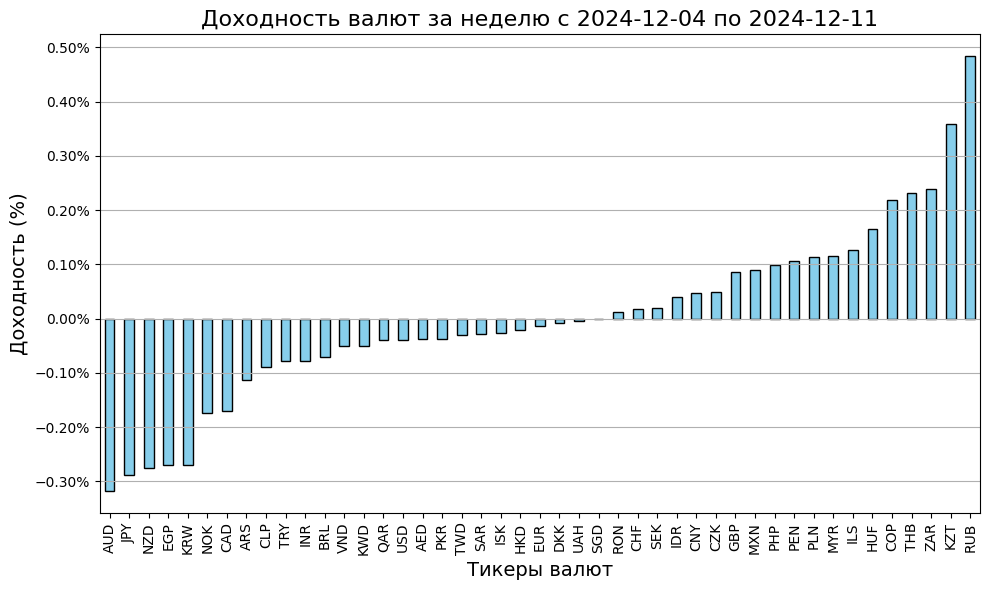

## За месяц (доходность)

Период: с 2024-11-11 по 2024-12-11.

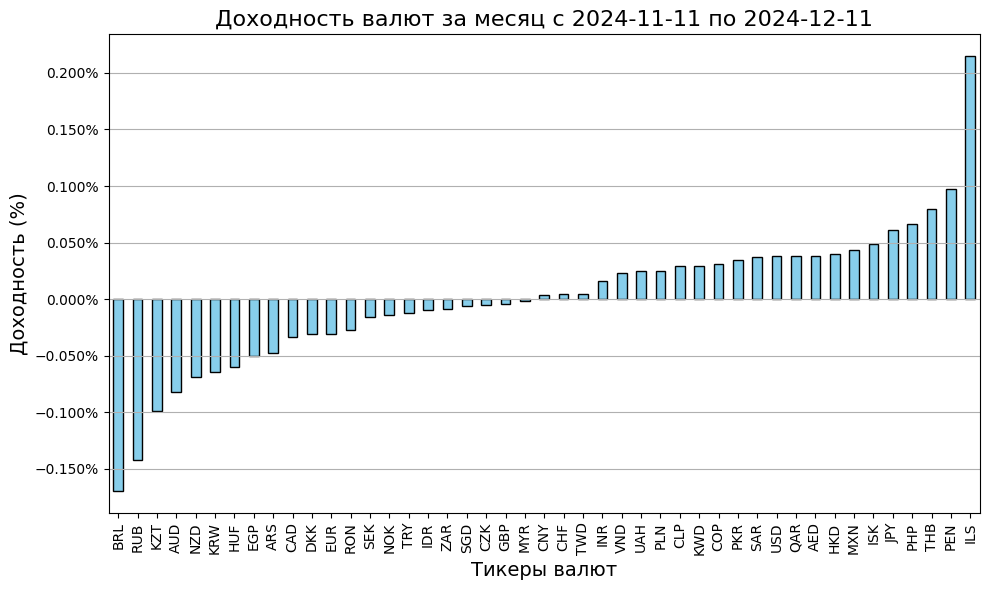

## За квартал (доходность)

Период: с 2024-09-11 по 2024-12-11.

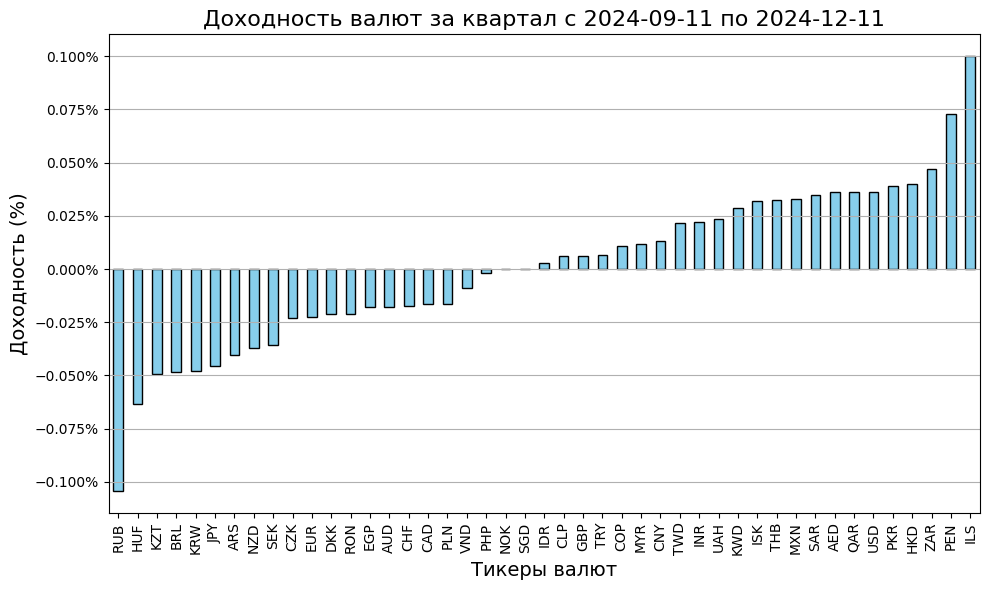

## За полгода (доходность)

Период: с 2024-06-11 по 2024-12-11.

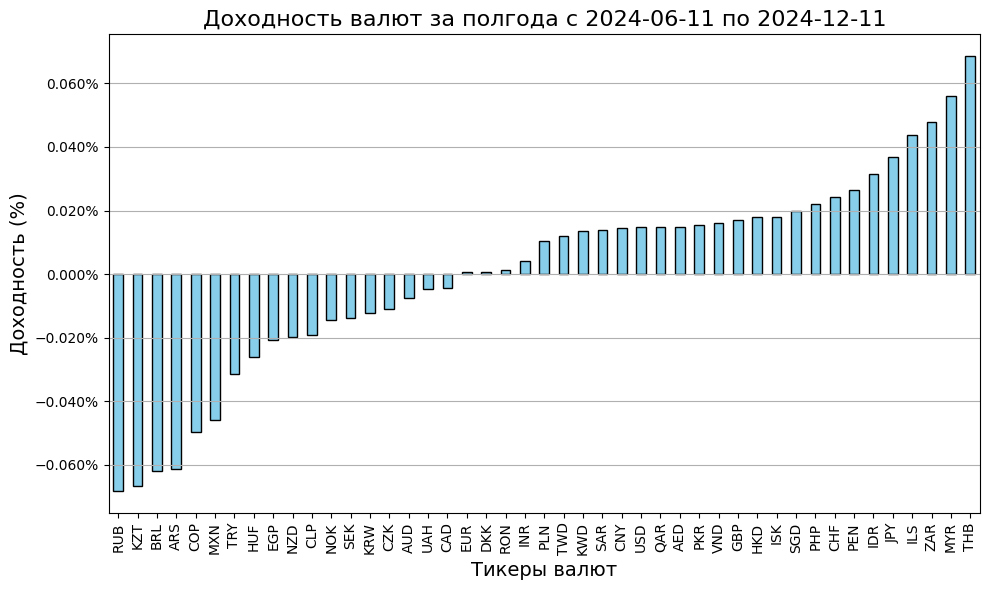

## За год (доходность)

Период: с 2023-12-11 по 2024-12-11.

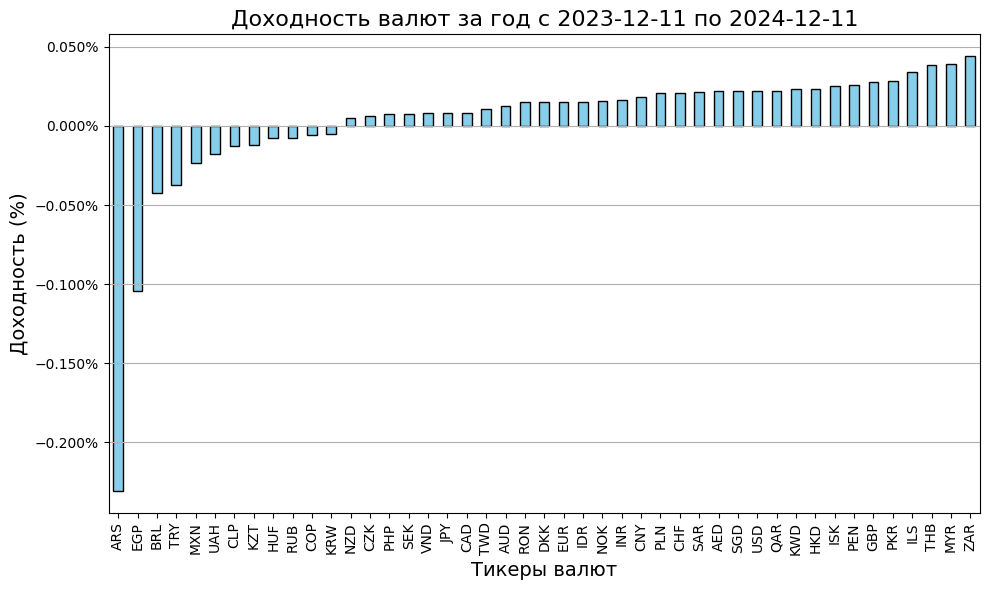

## За два года (доходность)

Период: с 2022-12-11 по 2024-12-11.

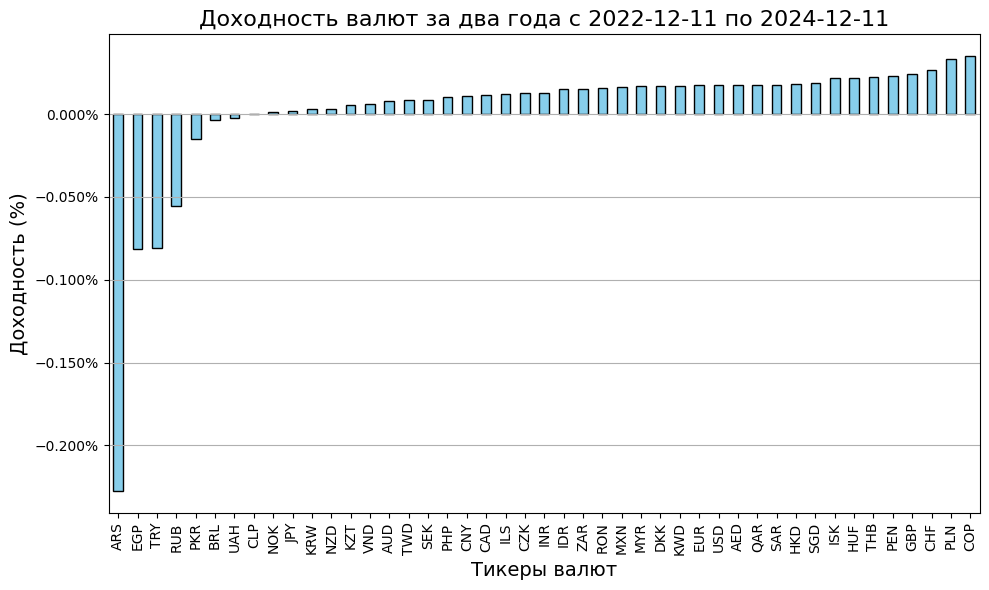

## За три года (доходность)

Период: с 2021-12-11 по 2024-12-11.

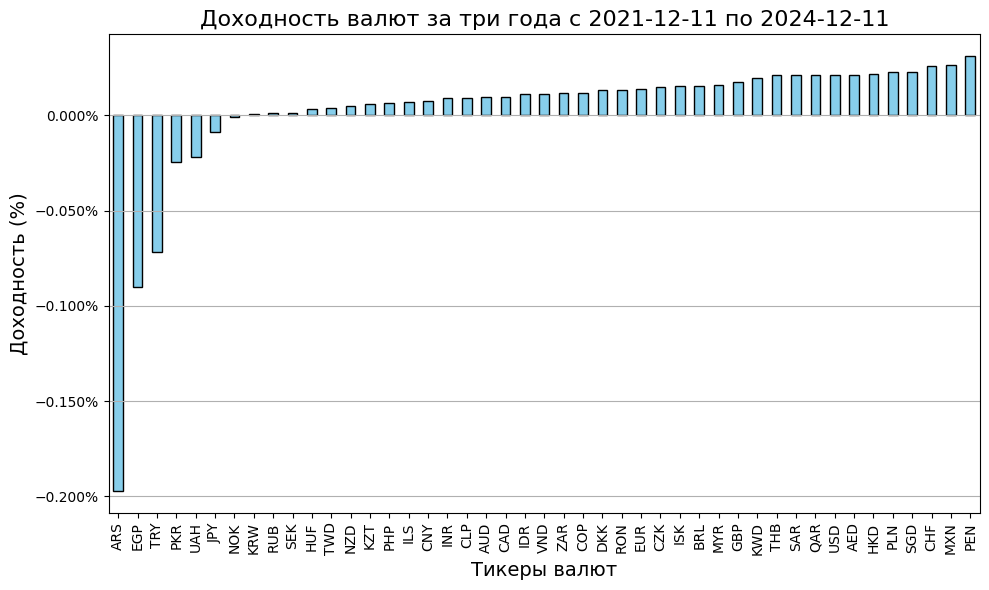

## За пять лет (доходность)

Период: с 2019-12-11 по 2024-12-11.

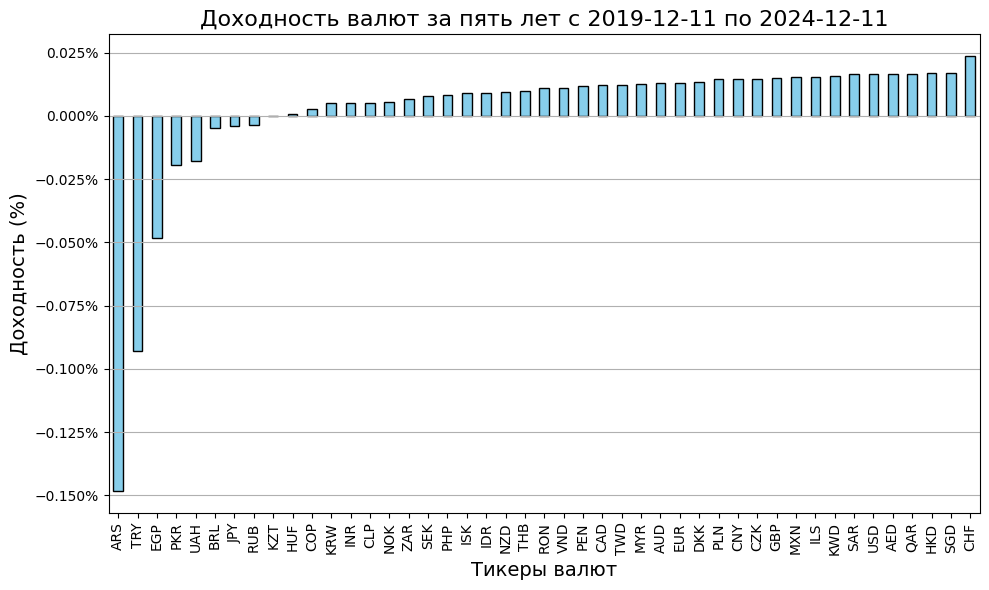

## За десять лет (доходность)

Период: с 2019-12-11 по 2024-12-11.

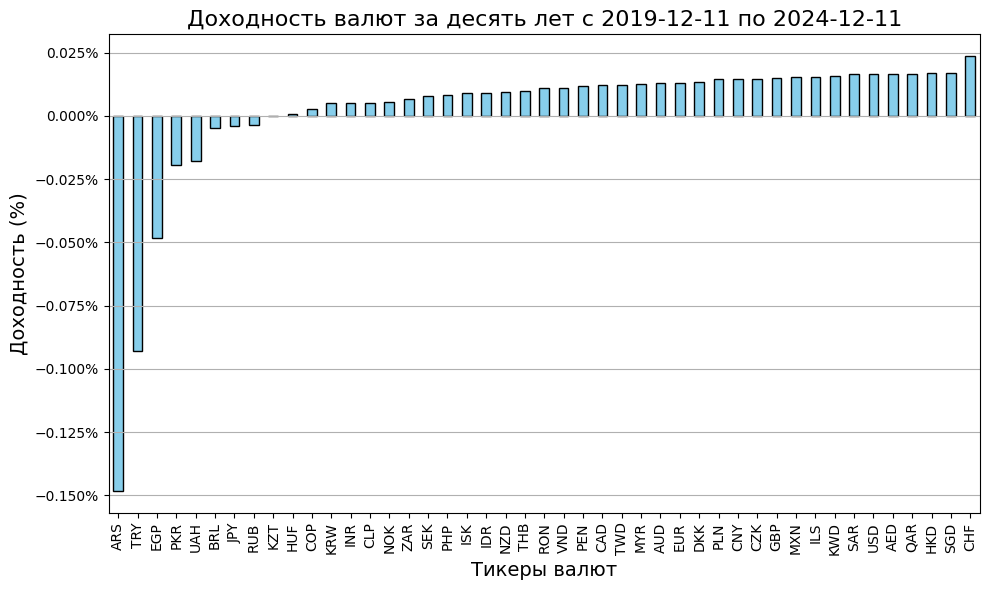

In [6]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from IPython.display import display, HTML, Markdown

# Проверка результата
for period, series in returns_series.items():
    sorted_series = series.sort_values()  # Сортируем значения по возрастанию

    # Вывод заголовка периода
    display(Markdown(f'## За {period} (доходность)'))
    
    # Вывод диапазона дат
    start_date = ago_dates[period]
    display(Markdown(f'Период: с {start_date.date()} по {today.date()}.'))  # Выводим даты в формате YYYY-MM-DD
    
    # Получаем 10 наиболее и наименее доходных тикеров
    top_gainers = sorted_series.nlargest(10)
    top_losers = sorted_series.nsmallest(10)

    # Формируем один абзац текста для топ-10 наиболее доходных акций
    gainers_text = "Топ 10 наиболее доходных валют: " + ", ".join(
        [f'{ticker}" ({change * 100:.2f}%)'
         for ticker, change in top_gainers.items()]
    )

    # Формируем один абзац текста для топ-10 наименее доходных акций
    losers_text = "Топ 10 наименее доходных валют: " + ", ".join(
        [f'{ticker}" ({change * 100:.2f}%)'
         for ticker, change in top_losers.items()]
    )

    # Выводим текст с гиперссылками
    display(HTML(gainers_text))
    display(HTML(losers_text))
    
    plt.figure(figsize=(10, 6))  # Устанавливаем размер фигуры
    sorted_series.plot(kind='bar', color='skyblue', edgecolor='black')
    
    plt.title(f'Доходность валют за {period} с {start_date.date()} по {today.date()}', fontsize=16)
    plt.xlabel('Тикеры валют', fontsize=14)
    plt.ylabel('Доходность (%)', fontsize=14)

    # Скрываем метки на оси X
    # plt.xticks([])  # Убираем метки с оси X

    # Форматируем вертикальную ось в процентах
    plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(1.0))  # Форматирование в процентах (0.01 = 1%)
    
    plt.grid(axis='y')  # Добавляем сетку по оси Y

    plt.tight_layout()  # Автоматически подгоняем параметры графика
    
    plt.show()  # Отображаем график

# Лидеры волатильности

## За неделю (волатильность)

Период: с 2024-12-04 по 2024-12-11.

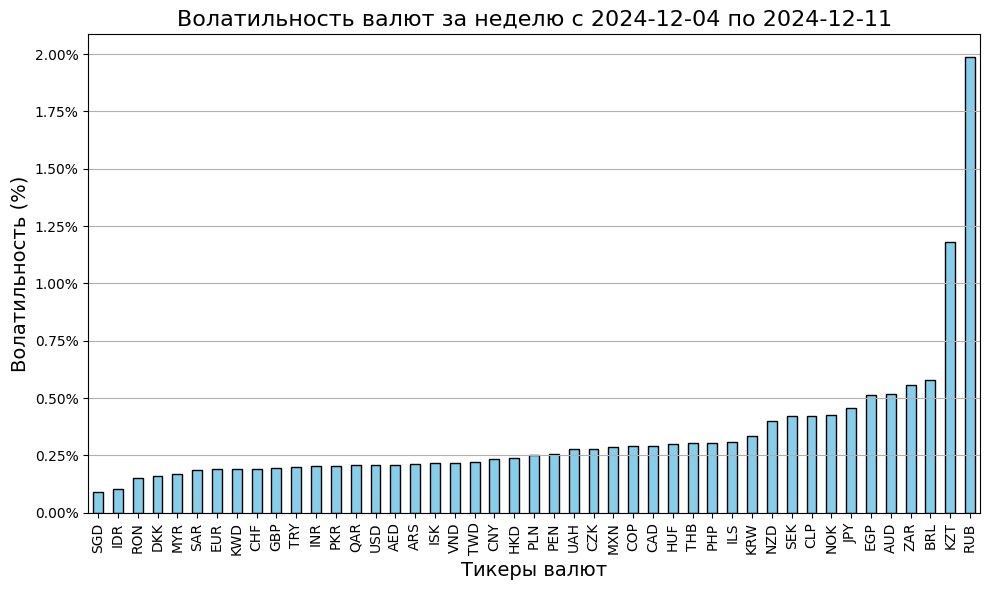

## За месяц (волатильность)

Период: с 2024-11-11 по 2024-12-11.

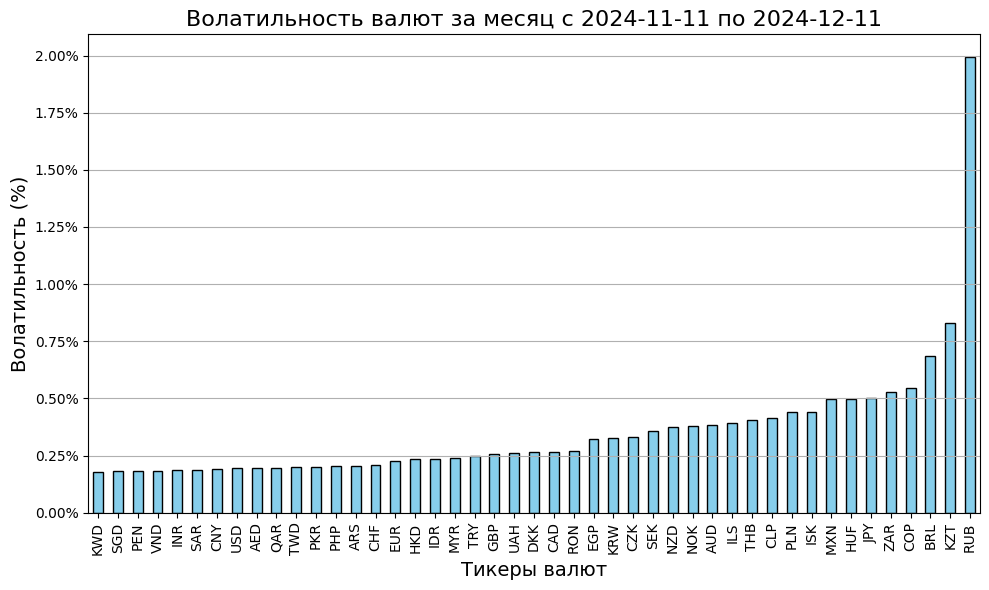

## За квартал (волатильность)

Период: с 2024-09-11 по 2024-12-11.

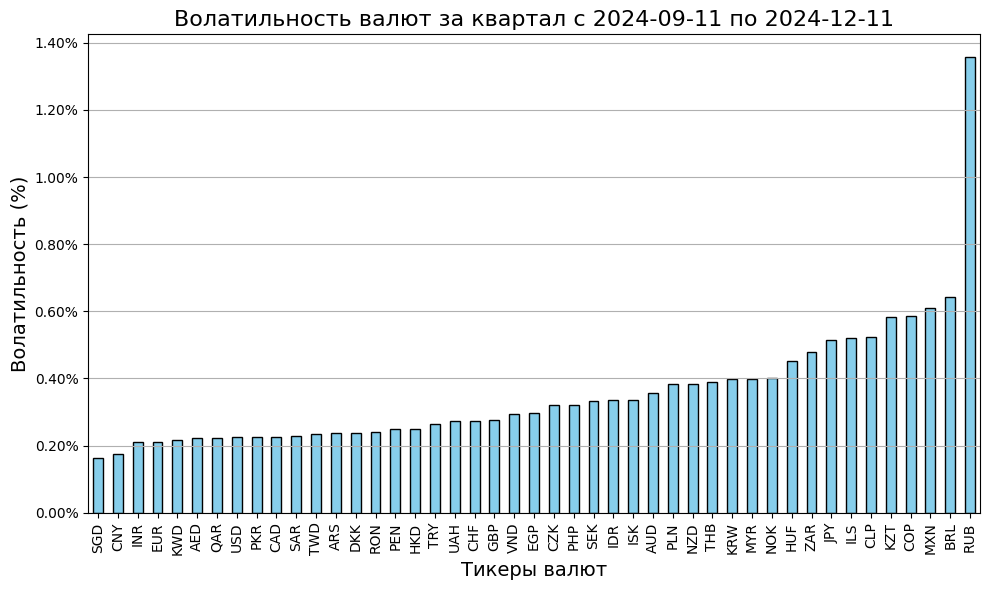

## За полгода (волатильность)

Период: с 2024-06-11 по 2024-12-11.

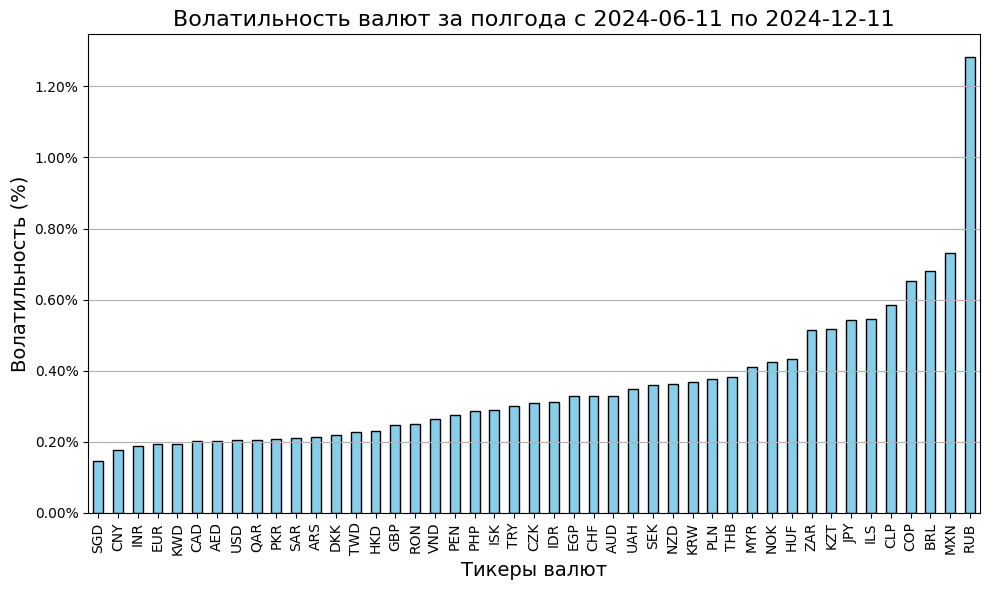

## За год (волатильность)

Период: с 2023-12-11 по 2024-12-11.

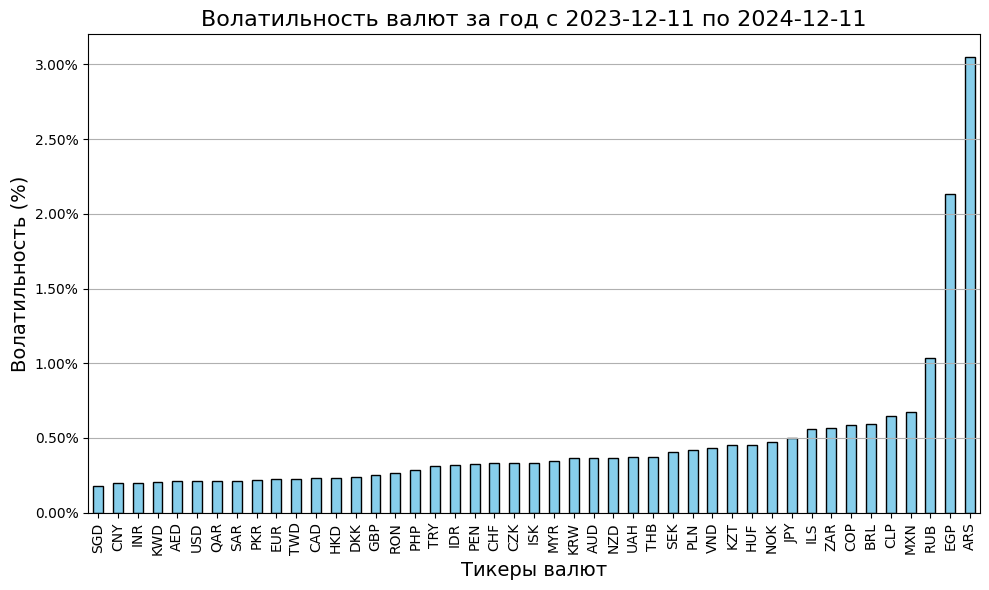

## За два года (волатильность)

Период: с 2022-12-11 по 2024-12-11.

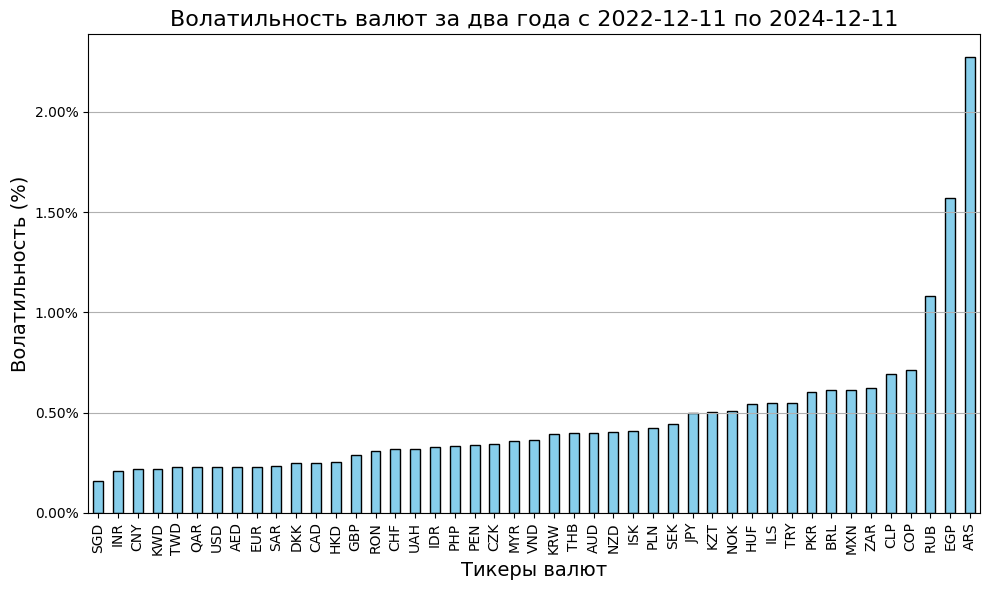

## За три года (волатильность)

Период: с 2021-12-11 по 2024-12-11.

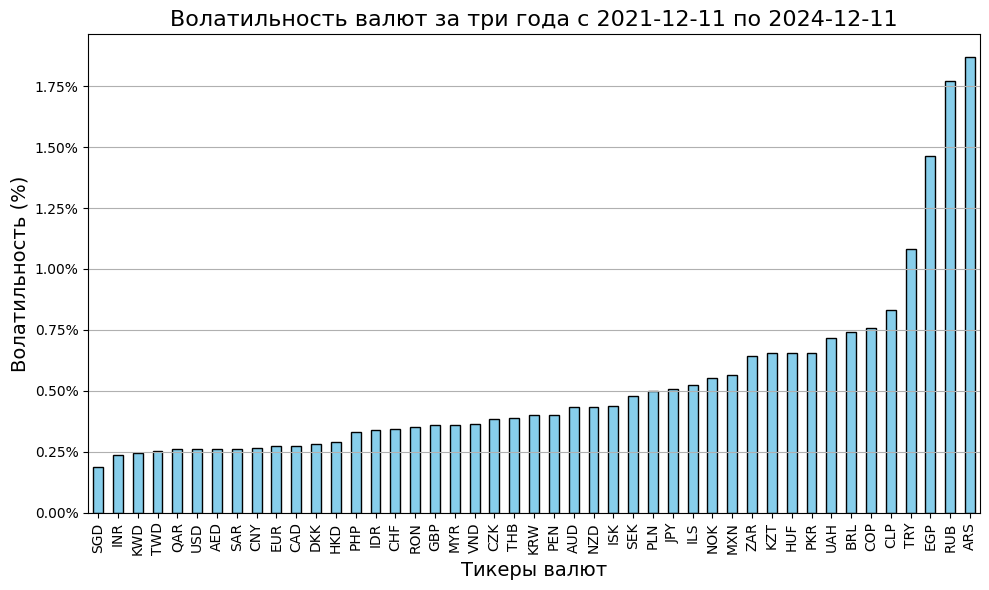

## За пять лет (волатильность)

Период: с 2019-12-11 по 2024-12-11.

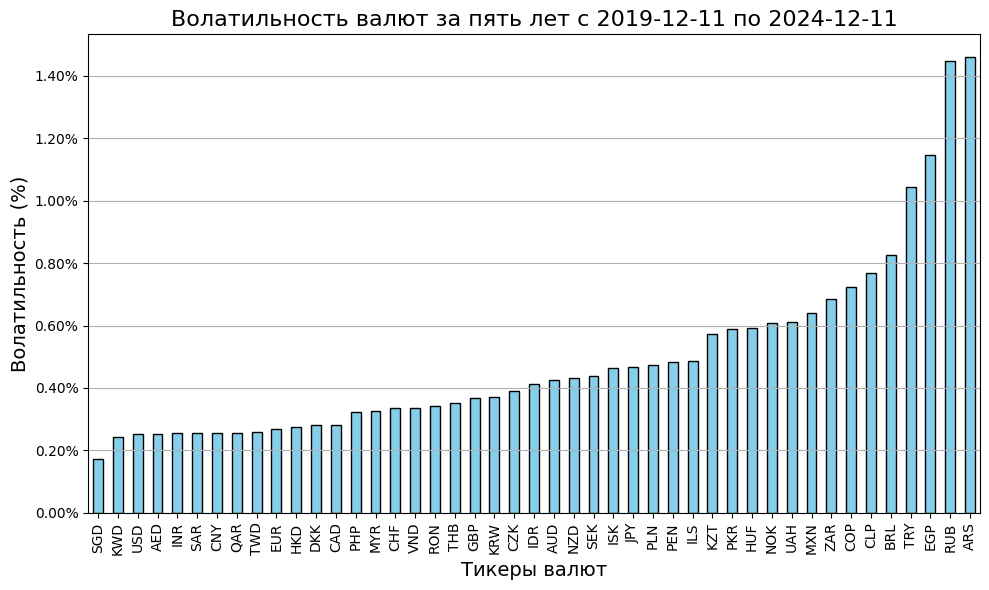

## За десять лет (волатильность)

Период: с 2019-12-11 по 2024-12-11.

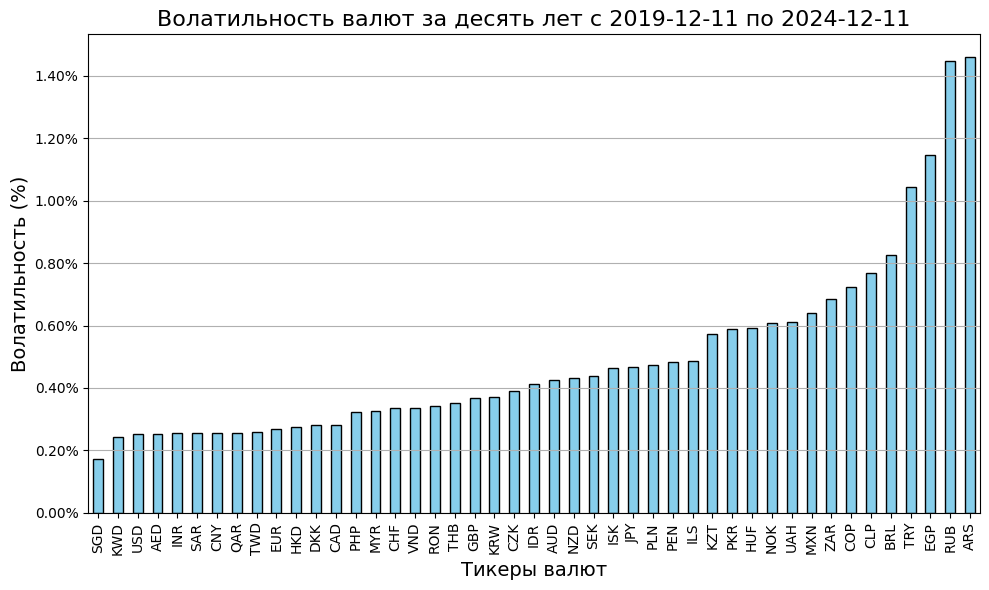

In [7]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from IPython.display import display, HTML, Markdown

# Проверка результата
for period, series in volat_series.items():
    sorted_series = series.sort_values()  # Сортируем значения по убыванию

    # Вывод заголовка периода
    display(Markdown(f'## За {period} (волатильность)'))
    
    # Вывод диапазона дат
    start_date = ago_dates[period]
    display(Markdown(f'Период: с {start_date.date()} по {today.date()}.'))  # Выводим даты в формате YYYY-MM-DD
    
    # Получаем 10 наименее и наиболее волатильных
    top_gainers = sorted_series.nsmallest(10)
    top_losers = sorted_series.nlargest(10)

    # Формируем один абзац текста для топ-10 наименее волатильных валют
    gainers_text = "Топ 10 наименее волатильных валют: " + ", ".join(
        [f'{ticker}" ({change * 100:.2f}%)'
         for ticker, change in top_gainers.items()]
    )

    # Формируем один абзац текста для топ-10 наиболее волатильных валют
    losers_text = "Топ 10 наиболее волатильных валют: " + ", ".join(
        [f'{ticker}" ({change * 100:.2f}%)'
         for ticker, change in top_losers.items()]
    )

    # Выводим текст с гиперссылками
    display(HTML(gainers_text))
    display(HTML(losers_text))
    
    plt.figure(figsize=(10, 6))  # Устанавливаем размер фигуры
    sorted_series.plot(kind='bar', color='skyblue', edgecolor='black')
    
    plt.title(f'Волатильность валют за {period} с {start_date.date()} по {today.date()}', fontsize=16)
    plt.xlabel('Тикеры валют', fontsize=14)
    plt.ylabel('Волатильность (%)', fontsize=14)

    # Форматируем вертикальную ось в процентах
    plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(1.0))  # Форматирование в процентах (0.01 = 1%)
    
    plt.grid(axis='y')  # Добавляем сетку по оси Y

    plt.tight_layout()  # Автоматически подгоняем параметры графика
    
    plt.show()  # Отображаем график

# Лидеры по коэффициенту Шарпа

## За неделю (по коэффициенту Шарпа)

Период: с 2024-12-04 по 2024-12-11.

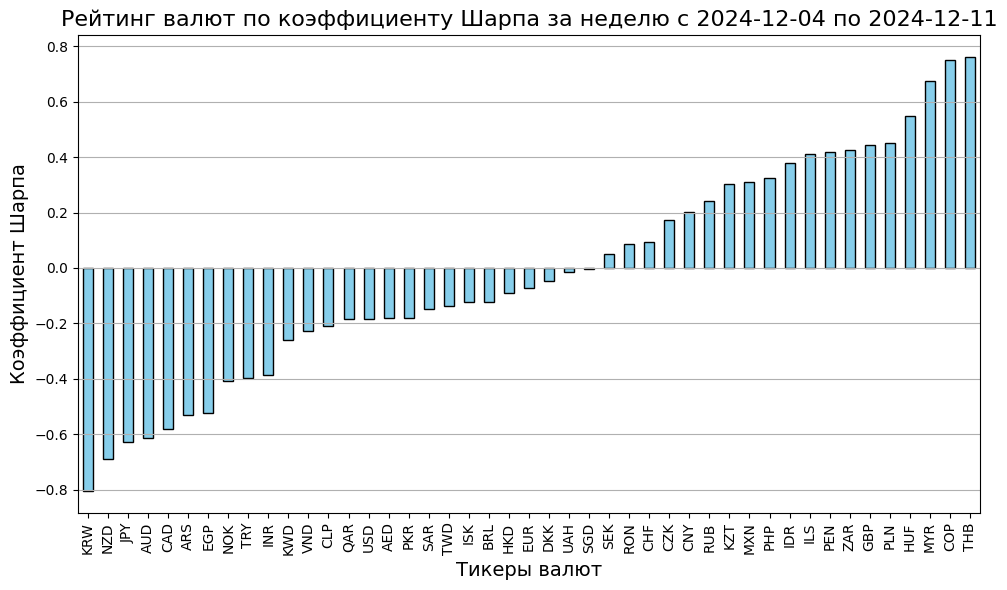

## За месяц (по коэффициенту Шарпа)

Период: с 2024-11-11 по 2024-12-11.

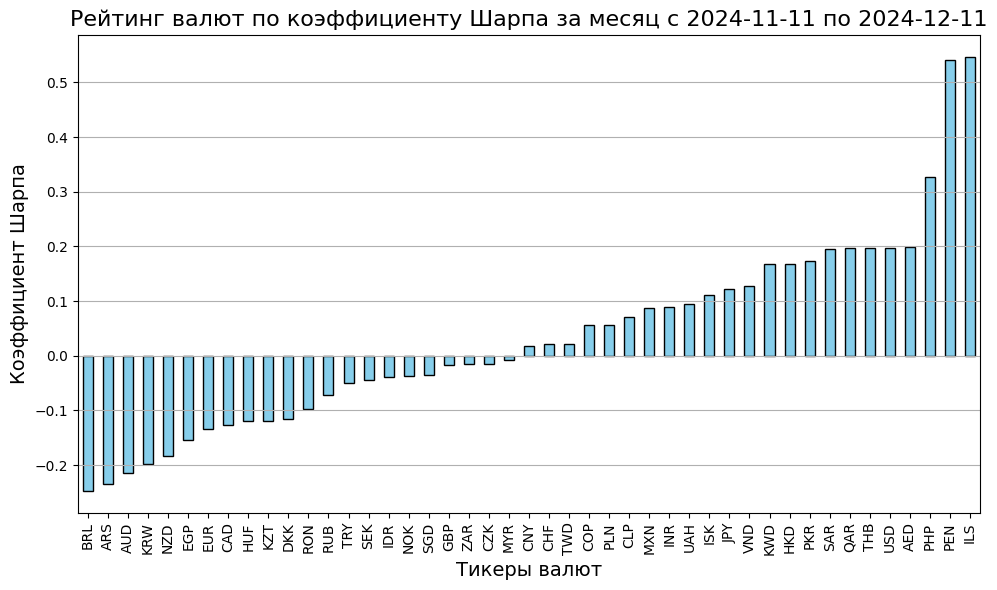

## За квартал (по коэффициенту Шарпа)

Период: с 2024-09-11 по 2024-12-11.

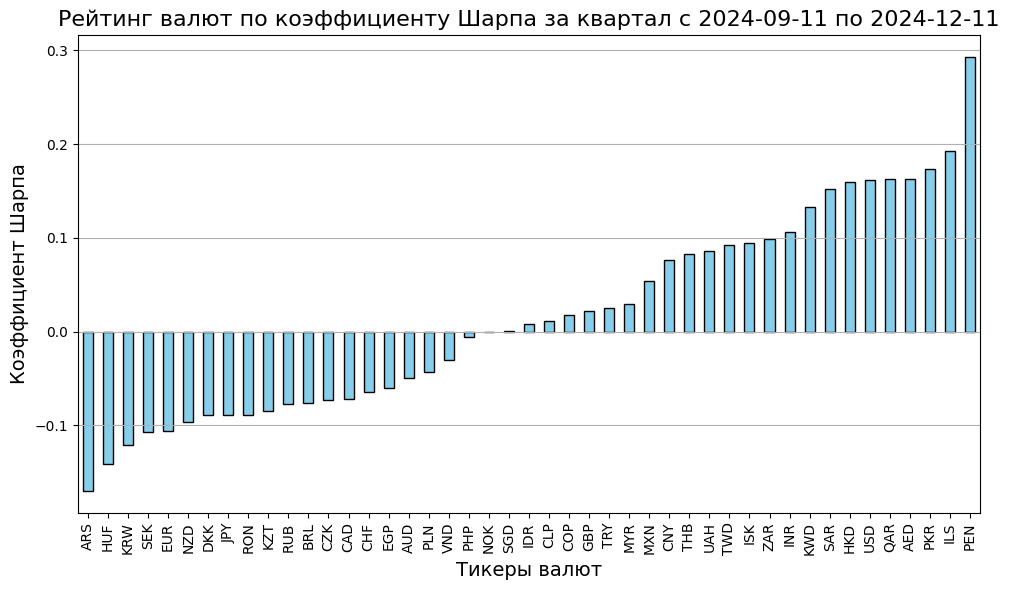

## За полгода (по коэффициенту Шарпа)

Период: с 2024-06-11 по 2024-12-11.

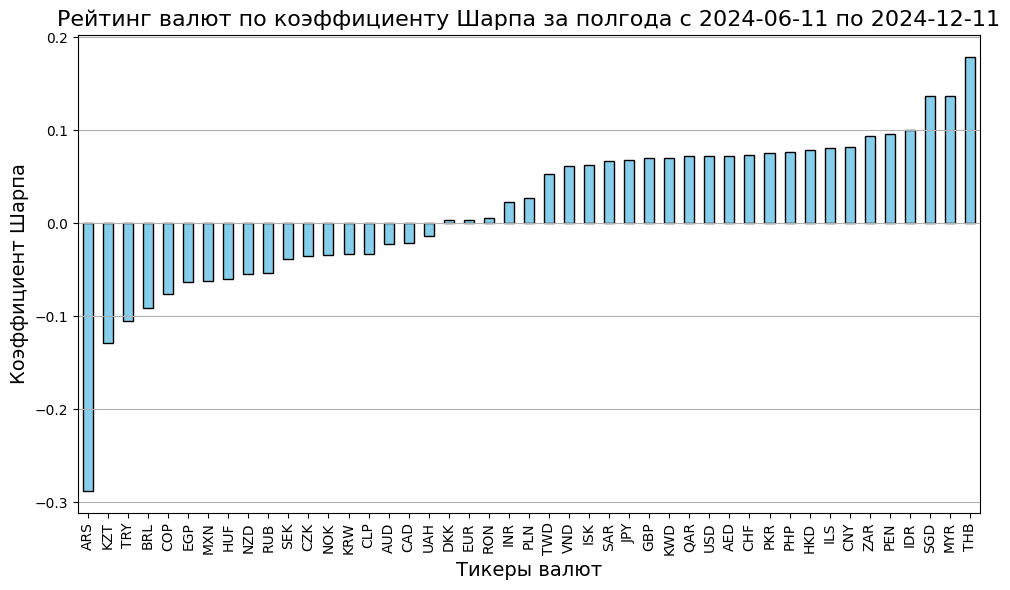

## За год (по коэффициенту Шарпа)

Период: с 2023-12-11 по 2024-12-11.

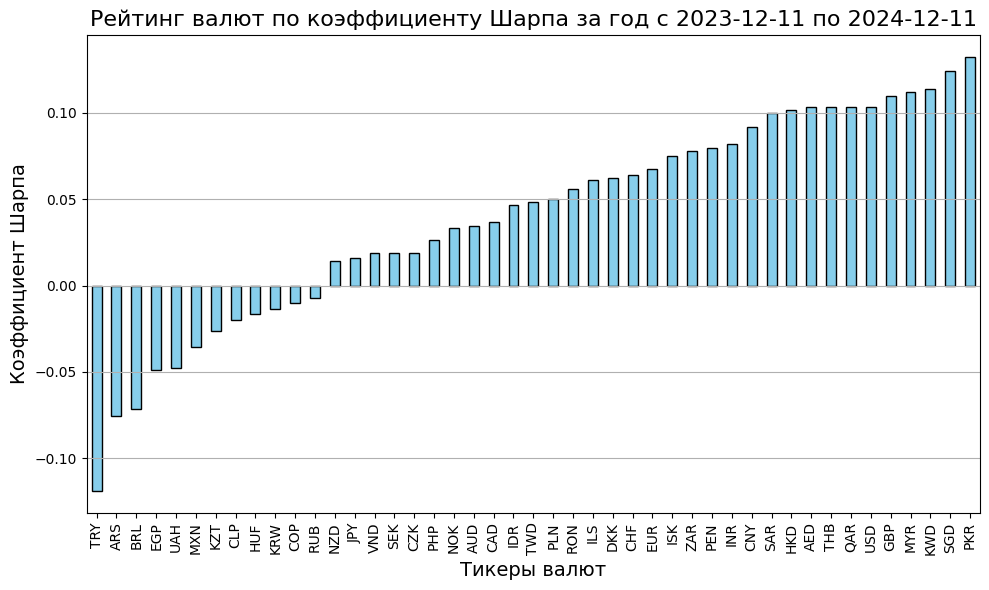

## За два года (по коэффициенту Шарпа)

Период: с 2022-12-11 по 2024-12-11.

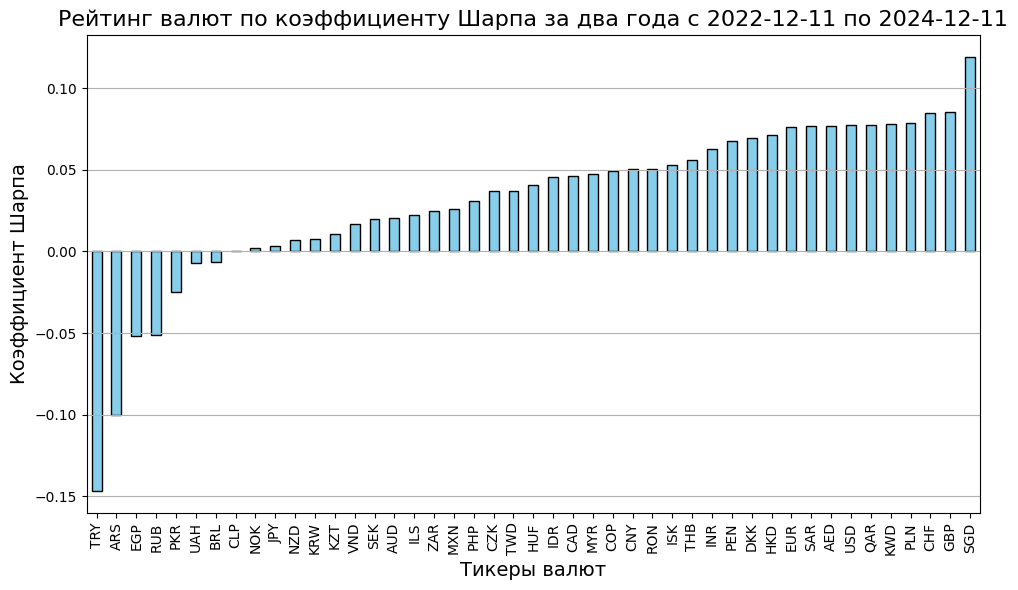

## За три года (по коэффициенту Шарпа)

Период: с 2021-12-11 по 2024-12-11.

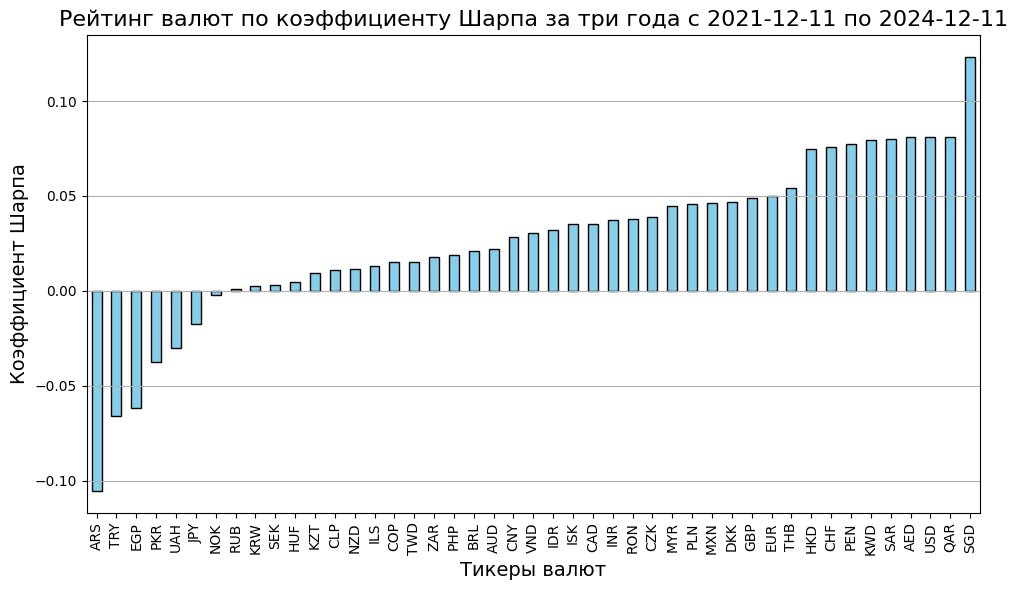

## За пять лет (по коэффициенту Шарпа)

Период: с 2019-12-11 по 2024-12-11.

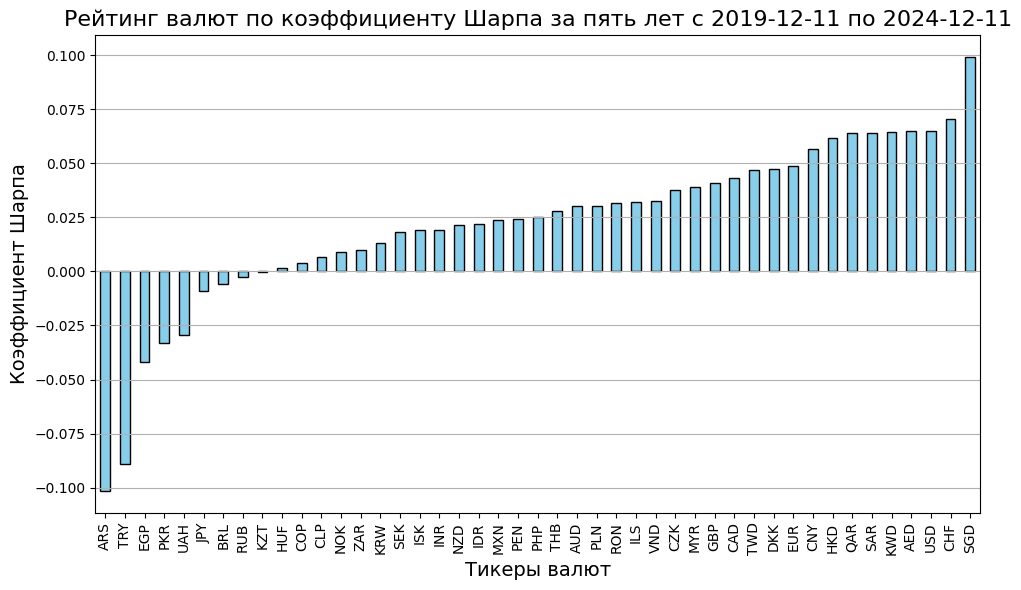

## За десять лет (по коэффициенту Шарпа)

Период: с 2019-12-11 по 2024-12-11.

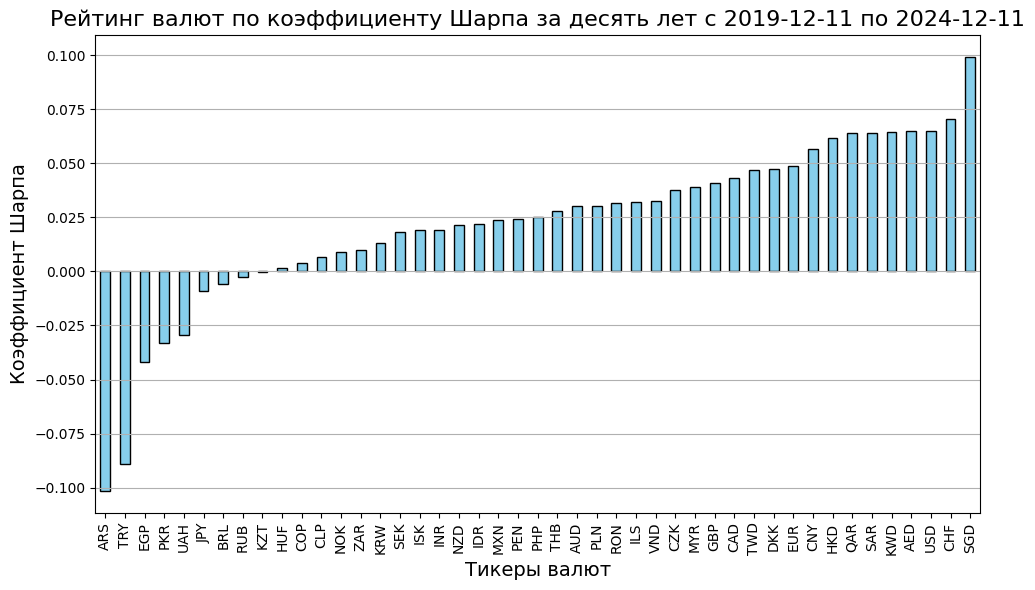

In [8]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from IPython.display import display, HTML, Markdown

# Проверка результата
for period, series in sharp_series.items():
    sorted_series = series.sort_values()  # Сортируем значения по возрастанию

    # Вывод заголовка периода
    display(Markdown(f'## За {period} (по коэффициенту Шарпа)'))
    
    # Вывод диапазона дат
    start_date = ago_dates[period]
    display(Markdown(f'Период: с {start_date.date()} по {today.date()}.'))  # Выводим даты в формате YYYY-MM-DD
    
    # Получаем 10 наиболее наиболее и наименее выгодных по коэффициенту Шарпа тикеров
    top_gainers = sorted_series.nlargest(10)
    top_losers = sorted_series.nsmallest(10)

    # Формируем один абзац текста для топ-10 наиболее выгодных по коэффициенту Шарпа валют
    gainers_text = "Топ 10 наиболее выгодных по коэффициенту Шарпа валют: " + ", ".join(
        [f'{ticker}" ({change:.2f})'
         for ticker, change in top_gainers.items()]
    )

    # Формируем один абзац текста для топ-10 наименее выгодных по коэффициенту Шарпа валют
    losers_text = "Топ 10 наименее выгодных по коэффициенту Шарпа валют: " + ", ".join(
        [f'{ticker}" ({change:.2f})'
         for ticker, change in top_losers.items()]
    )

    # Выводим текст с гиперссылками
    display(HTML(gainers_text))
    display(HTML(losers_text))
    
    plt.figure(figsize=(10, 6))  # Устанавливаем размер фигуры
    sorted_series.plot(kind='bar', color='skyblue', edgecolor='black')
    
    plt.title(f'Рейтинг валют по коэффициенту Шарпа за {period} с {start_date.date()} по {today.date()}', fontsize=16)
    plt.xlabel('Тикеры валют', fontsize=14)
    plt.ylabel('Коэффициент Шарпа', fontsize=14)

    # Скрываем метки на оси X
    # plt.xticks([])  # Убираем метки с оси X

    plt.grid(axis='y')  # Добавляем сетку по оси Y

    plt.tight_layout()  # Автоматически подгоняем параметры графика
    
    plt.show()  # Отображаем график

# Лидеры по коэффициенту Сортино

## За неделю (по коэффициенту Сортино)

Период: с 2024-12-04 по 2024-12-11.

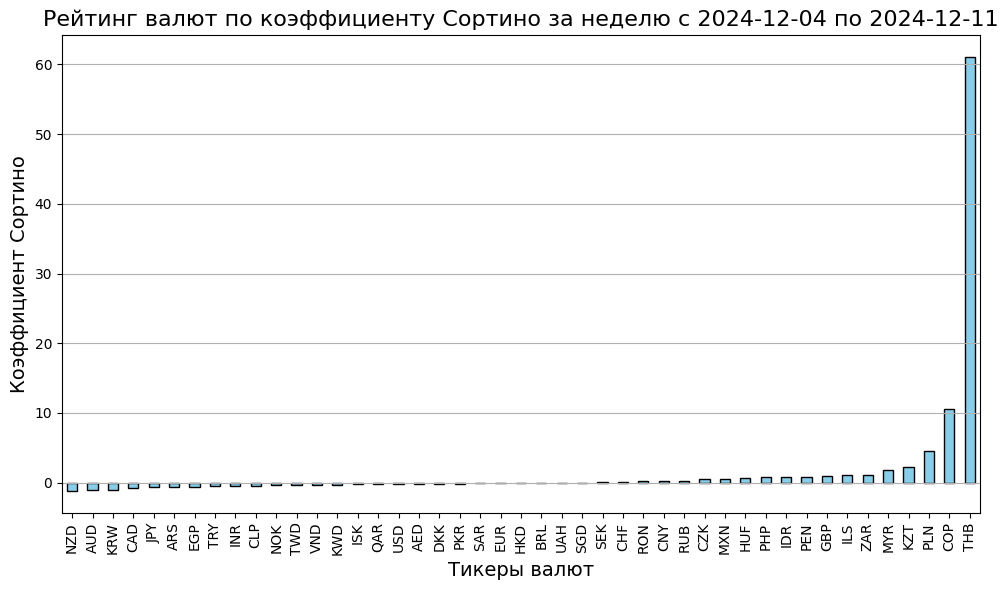

## За месяц (по коэффициенту Сортино)

Период: с 2024-11-11 по 2024-12-11.

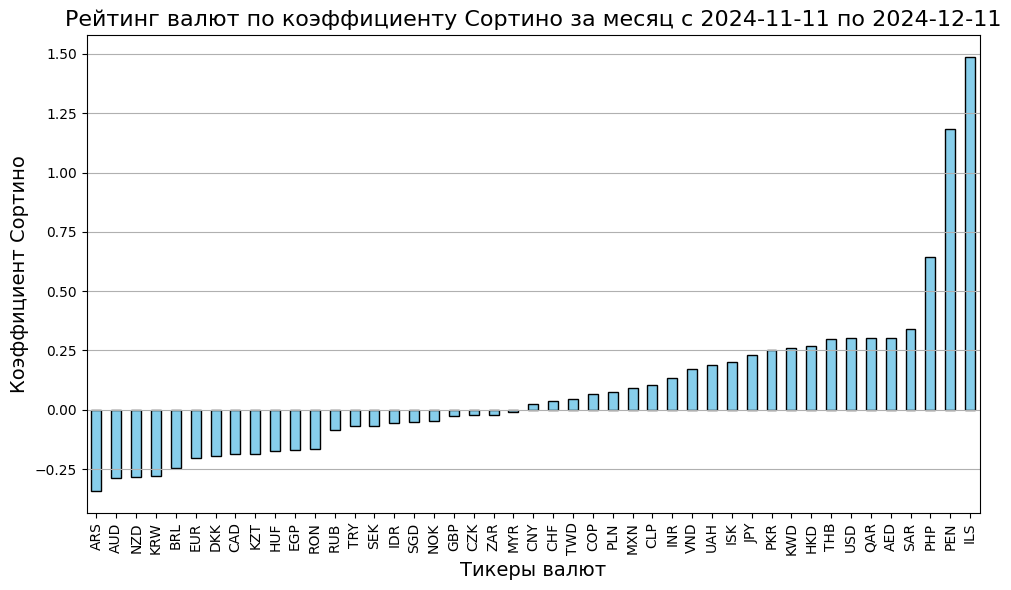

## За квартал (по коэффициенту Сортино)

Период: с 2024-09-11 по 2024-12-11.

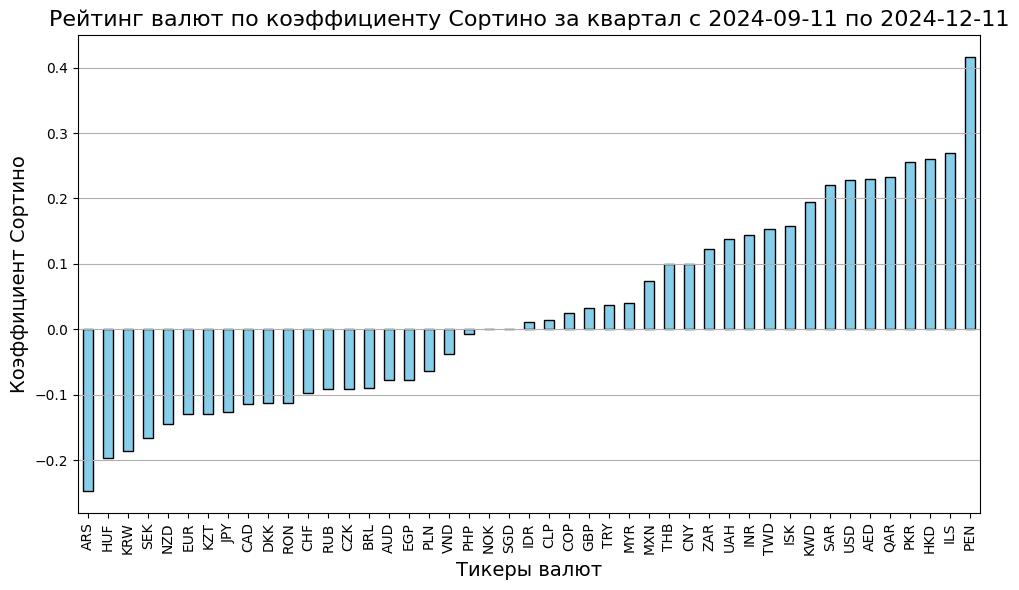

## За полгода (по коэффициенту Сортино)

Период: с 2024-06-11 по 2024-12-11.

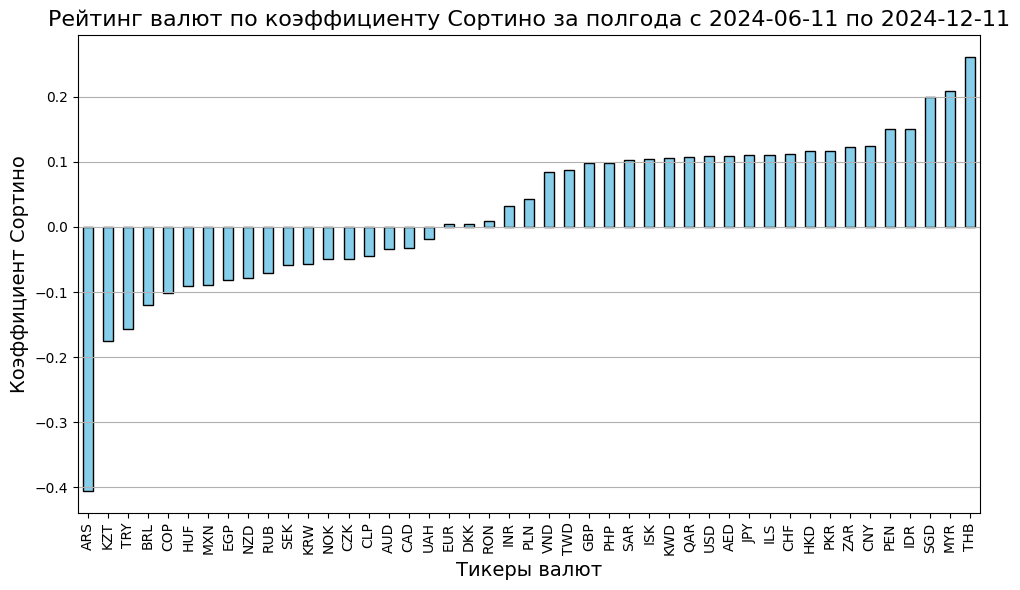

## За год (по коэффициенту Сортино)

Период: с 2023-12-11 по 2024-12-11.

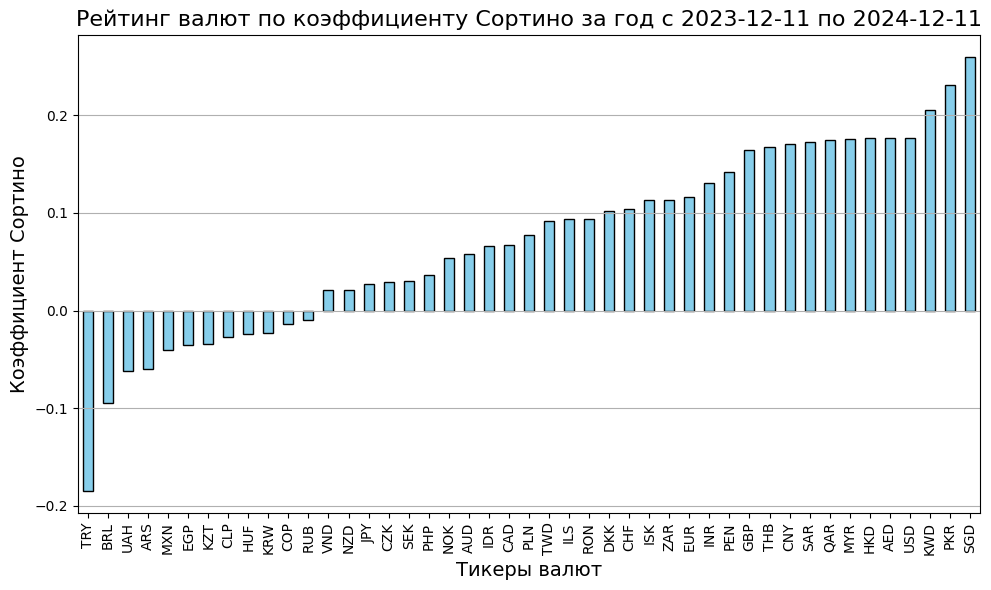

## За два года (по коэффициенту Сортино)

Период: с 2022-12-11 по 2024-12-11.

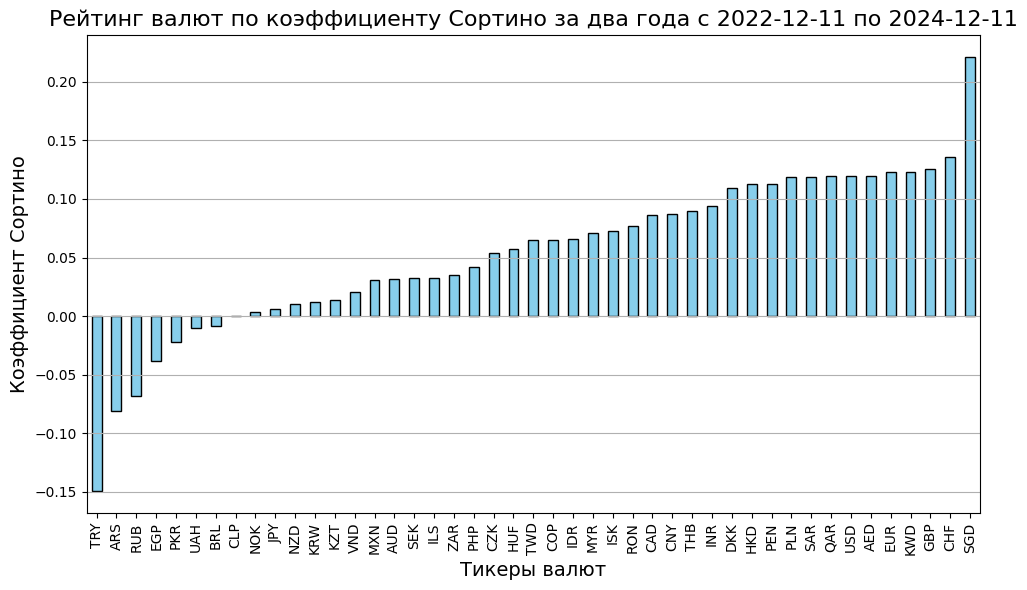

## За три года (по коэффициенту Сортино)

Период: с 2021-12-11 по 2024-12-11.

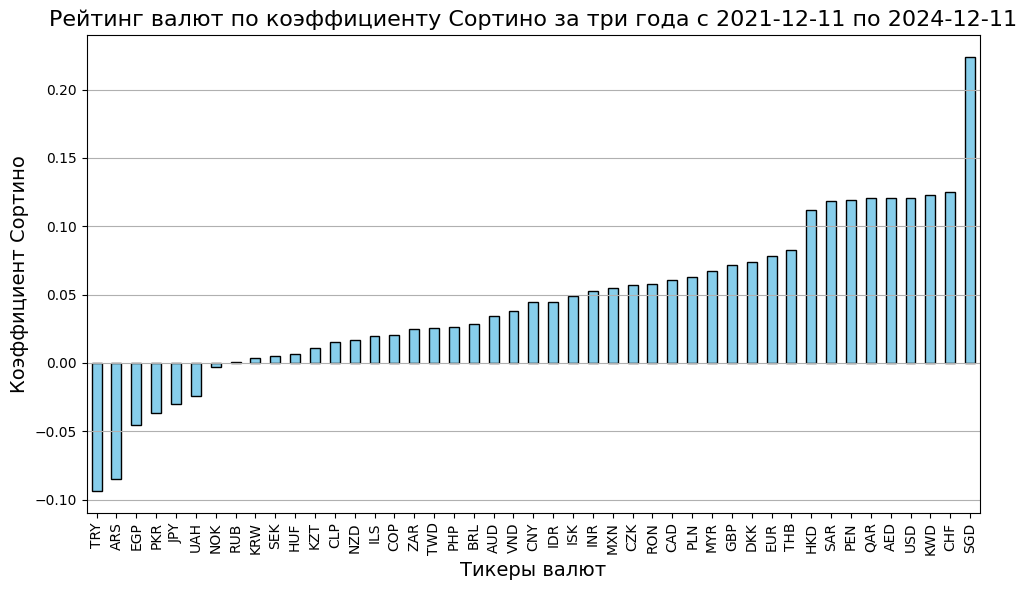

## За пять лет (по коэффициенту Сортино)

Период: с 2019-12-11 по 2024-12-11.

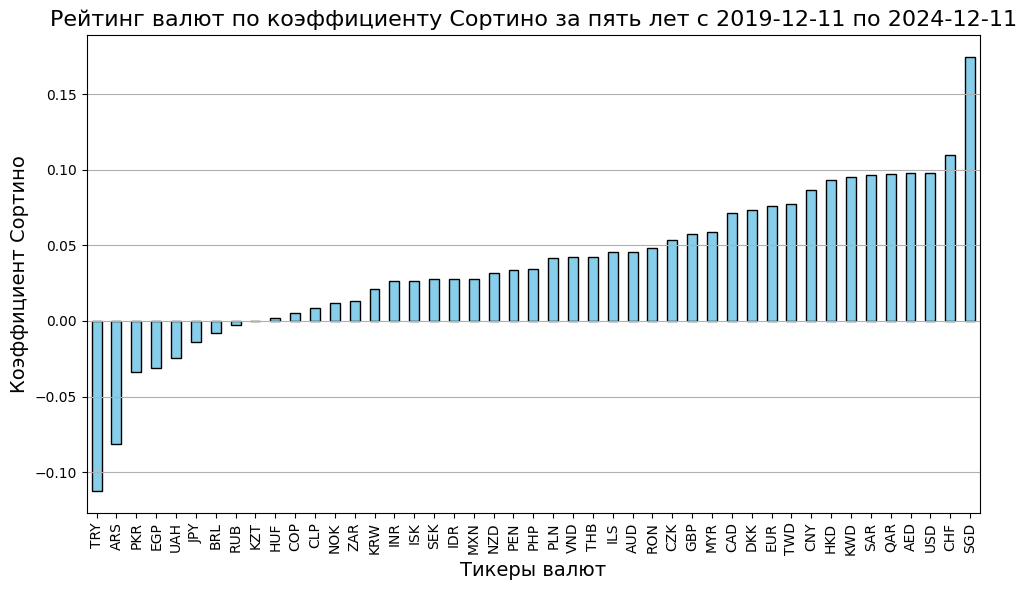

## За десять лет (по коэффициенту Сортино)

Период: с 2019-12-11 по 2024-12-11.

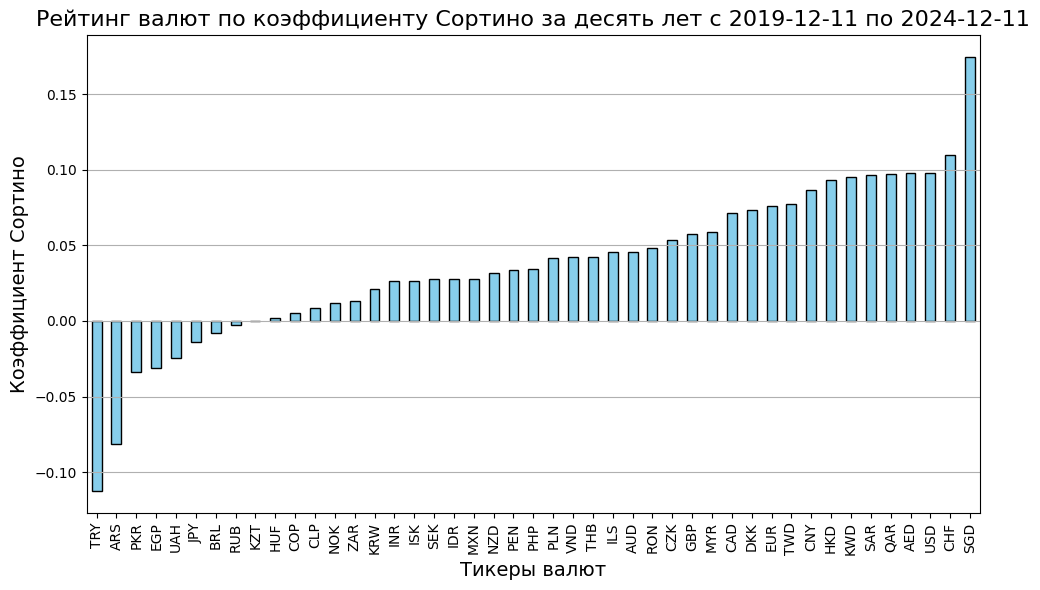

In [9]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from IPython.display import display, HTML, Markdown

# Проверка результата
for period, series in sortino_series.items():
    sorted_series = series.sort_values()  # Сортируем значения по возрастанию

    # Вывод заголовка периода
    display(Markdown(f'## За {period} (по коэффициенту Сортино)'))
    
    # Вывод диапазона дат
    start_date = ago_dates[period]
    display(Markdown(f'Период: с {start_date.date()} по {today.date()}.'))  # Выводим даты в формате YYYY-MM-DD
    
    # Получаем 10 наиболее наиболее и наименее выгодных по коэффициенту Сортино тикеров
    top_gainers = sorted_series.nlargest(10)
    top_losers = sorted_series.nsmallest(10)

    # Формируем один абзац текста для топ-10 наиболее выгодных по коэффициенту Сортино валют
    gainers_text = "Топ 10 наиболее выгодных по коэффициенту Сортино валют: " + ", ".join(
        [f'{ticker}" ({change:.2f})'
         for ticker, change in top_gainers.items()]
    )

    # Формируем один абзац текста для топ-10 наименее выгодных по коэффициенту Шарпа валют
    losers_text = "Топ 10 наименее выгодных по коэффициенту Сортино валют: " + ", ".join(
        [f'{ticker}" ({change:.2f})'
         for ticker, change in top_losers.items()]
    )

    # Выводим текст с гиперссылками
    display(HTML(gainers_text))
    display(HTML(losers_text))
    
    plt.figure(figsize=(10, 6))  # Устанавливаем размер фигуры
    sorted_series.plot(kind='bar', color='skyblue', edgecolor='black')
    
    plt.title(f'Рейтинг валют по коэффициенту Сортино за {period} с {start_date.date()} по {today.date()}', fontsize=16)
    plt.xlabel('Тикеры валют', fontsize=14)
    plt.ylabel('Коэффициент Сортино', fontsize=14)

    plt.grid(axis='y')  # Добавляем сетку по оси Y

    plt.tight_layout()  # Автоматически подгоняем параметры графика
    
    plt.show()  # Отображаем график